In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from scipy.misc import imread, imresize, imshow

import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.contrib.slim.nets import vgg

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, recall_score

## Params, paths, constants

In [2]:
pretrain_checkpoint = './data/models/vgg_16.ckpt'
checkpoint_scope_name = 'vgg_16'

log_dir = './log/'
save_path = './models/'

IMAGE_FOLDER_PATH = './data/resized/frames/'
LABEL_FOLDER_PATH = './data/labels/'
MODEL_SAVE_PATH = './models/better_split.model'

In [3]:
stream_names = [
    'head_stream',
    'hand_stream',
]

excluded_layers = ['fc6','fc7', 'fc8']

In [4]:
batch_size = 64
num_classes = 24

## Load data

In [5]:
def sub_segments(l, segment_count, ratio):
    segment_size = round(len(l)*ratio)//segment_count
    
    

def split_train_val_by_labels(head_paths, hand_paths, labels, train_ratio=0.7):
    train_idxes = []
    val_idxes = []
    classes, counts = np.unique(labels, return_counts=True)
    for class_, count in zip(classes,counts):
        class_idxes = np.where(labels==class_)[0]
        class_train_count = int(count*train_ratio)
        train_idxes.append(class_idxes[:class_train_count])
        val_idxes.append(class_idxes[class_train_count:])
    train_idxes = np.hstack(train_idxes)
    val_idxes = np.hstack(val_idxes)
    
    return head_paths[train_idxes], hand_paths[train_idxes], labels[train_idxes], \
           head_paths[val_idxes], hand_paths[val_idxes], labels[val_idxes]

In [6]:
from data_helper import load_examples, load_examples
from sklearn.model_selection import train_test_split

h_image_paths, l_image_paths, r_image_paths, l_labels, r_labels = \
    load_examples(image_folder_path=IMAGE_FOLDER_PATH,
                  label_folder_path=LABEL_FOLDER_PATH,
                  data_type='train', label_type='obj', 
                  hand_type='both', with_head=True)
    
h_image_paths = np.array(h_image_paths)
l_image_paths = np.array(l_image_paths)
r_image_paths = np.array(r_image_paths)
    
# head_image_paths = np.array(h_image_paths + h_image_paths)
# hand_image_paths = np.array(l_image_paths + r_image_paths)
# labels = np.hstack([l_labels, r_labels])

# # shuffle to make train/val split better
# shuffle_idx = np.arange(head_image_paths.shape[0])
# np.random.shuffle(shuffle_idx)
# head_image_paths = head_image_paths[shuffle_idx]
# hand_image_paths = hand_image_paths[shuffle_idx]
# labels = labels[shuffle_idx]

# train/val split
l_train_head_paths, l_train_hand_paths, l_train_labels, l_val_head_paths, l_val_hand_paths, l_val_labels = \
    split_train_val_by_labels(h_image_paths, l_image_paths, l_labels, train_ratio=0.7)
r_train_head_paths, r_train_hand_paths, r_train_labels, r_val_head_paths, r_val_hand_paths, r_val_labels = \
    split_train_val_by_labels(h_image_paths, r_image_paths, r_labels, train_ratio=0.7)

join = lambda x,y: np.hstack([x,y])

In [7]:
train_head_paths = join(l_train_head_paths, r_train_head_paths)
train_hand_paths = join(l_train_hand_paths, r_train_hand_paths)
train_labels = join(l_train_labels, r_train_labels)

val_head_paths = join(l_val_head_paths, r_val_head_paths)
val_hand_paths = join(l_val_hand_paths, r_val_hand_paths)
val_labels = join(l_val_labels, r_val_labels)

# none empty frames data

train_head_paths_no_empty = join(l_train_head_paths, r_train_head_paths)[train_labels!=0]
train_hand_paths_no_empty = join(l_train_hand_paths, r_train_hand_paths)[train_labels!=0]
train_labels_no_empty = join(l_train_labels, r_train_labels)[train_labels!=0]

val_head_paths_no_empty = join(l_val_head_paths, r_val_head_paths)[val_labels!=0]
val_hand_paths_no_empty = join(l_val_hand_paths, r_val_hand_paths)[val_labels!=0]
val_labels_no_empty = join(l_val_labels, r_val_labels)[val_labels!=0]


# train_head_paths = join(r_train_hand_paths, l_train_hand_paths)
# train_hand_paths = join(l_train_hand_paths, r_train_hand_paths)
# train_labels = join(l_train_labels, r_train_labels)

# val_head_paths = join(r_val_hand_paths, l_val_hand_paths)
# val_hand_paths = join(l_val_hand_paths, r_val_hand_paths)
# val_labels = join(l_val_labels, r_val_labels)

# # none empty frames data

# train_head_paths_no_empty = join(r_train_hand_paths, l_train_hand_paths)[train_labels!=0]
# train_hand_paths_no_empty = join(l_train_hand_paths, r_train_hand_paths)[train_labels!=0]
# train_labels_no_empty = join(l_train_labels, r_train_labels)[train_labels!=0]

# val_head_paths_no_empty = join(r_val_hand_paths, l_val_hand_paths)[val_labels!=0]
# val_hand_paths_no_empty = join(l_val_hand_paths, r_val_hand_paths)[val_labels!=0]
# val_labels_no_empty = join(l_val_labels, r_val_labels)[val_labels!=0]

In [8]:
test_h_paths, test_l_paths, test_r_paths, test_l_labels, test_r_labels = \
    load_examples(image_folder_path=IMAGE_FOLDER_PATH,
                  label_folder_path=LABEL_FOLDER_PATH,
                  data_type='test', label_type='obj', 
                  hand_type='both', with_head=True)
    
# Combine left hand and right hand as a same stream
test_head_paths = test_h_paths + test_h_paths
test_hand_paths = test_l_paths + test_r_paths
test_labels = np.hstack([test_l_labels, test_r_labels])

In [9]:
def vis_label_distribution(labels, title=None):
    v, c = np.unique(labels, return_counts=True)
    full_counts = np.zeros(num_classes)
    for i,vv in enumerate(v):
        full_counts[int(vv)] = c[i]
    plt.plot(full_counts)
    if title:
        plt.title(title)
    plt.show()

## Simple visualize distribution

In [35]:
print('Class 0 ratio: ', sum(train_labels==0) / len(train_labels))

Class 0 ratio:  0.482910063013


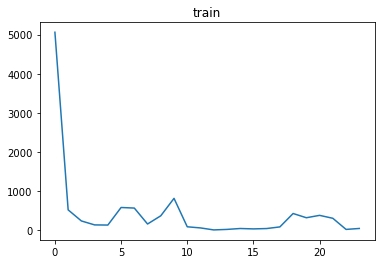

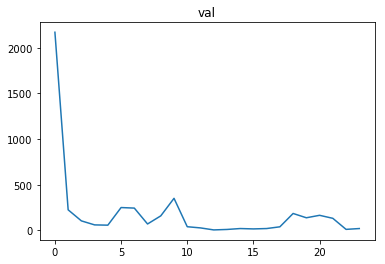

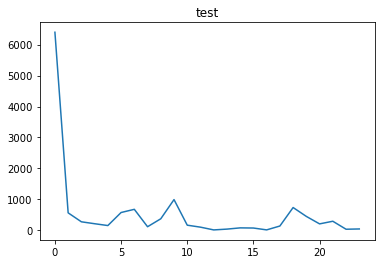

In [10]:
vis_label_distribution(train_labels, 'train')
vis_label_distribution(val_labels, 'val')
vis_label_distribution(test_labels, 'test')

## Pre-procssing / augmentation

In [11]:
'''
From TF source code:
https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/contrib/image/python/ops/image_ops.py
'''

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
from tensorflow.contrib.image import transform

_IMAGE_DTYPES = set([dtypes.uint8, dtypes.int32, dtypes.int64, dtypes.float32, dtypes.float64])

def rotate(images, angles, interpolation="NEAREST"):
    image_or_images = ops.convert_to_tensor(images, name="images")
    if image_or_images.dtype.base_dtype not in _IMAGE_DTYPES:
        raise TypeError("Invalid dtype %s." % image_or_images.dtype)
    if len(image_or_images.get_shape()) == 2:
        images = image_or_images[None, :, :, None]
    elif len(image_or_images.get_shape()) == 3:
        images = image_or_images[None, :, :, :]
    elif len(image_or_images.get_shape()) == 4:
        images = image_or_images
    else:
        raise TypeError("Images should have rank between 2 and 4.")

    image_height = math_ops.cast(array_ops.shape(images)[1], dtypes.float32)[None]
    image_width = math_ops.cast(array_ops.shape(images)[2], dtypes.float32)[None]
    output = transform(
        images,
        angles_to_projective_transforms(angles, image_height, image_width),
        interpolation=interpolation)
    if len(image_or_images.get_shape()) == 2:
        return output[0, :, :, 0]
    elif len(image_or_images.get_shape()) == 3:
        return output[0, :, :, :]
    else:
        return output


def angles_to_projective_transforms(angle_or_angles, image_height, image_width):
    if len(angle_or_angles.get_shape()) == 0:  # pylint: disable=g-explicit-length-test
        angles = angle_or_angles[None]
    elif len(angle_or_angles.get_shape()) == 1:
        angles = angle_or_angles
    else:
        raise TypeError("Angles should have rank 0 or 1.")
    x_offset = ((image_width - 1) - (math_ops.cos(angles) *
                                   (image_width - 1) - math_ops.sin(angles) *
                                   (image_height - 1))) / 2.0
    y_offset = ((image_height - 1) - (math_ops.sin(angles) *
                                    (image_width - 1) + math_ops.cos(angles) *
                                    (image_height - 1))) / 2.0
    num_angles = array_ops.shape(angles)[0]
    return array_ops.concat(
        values=[
          math_ops.cos(angles)[:, None],
          -math_ops.sin(angles)[:, None],
          x_offset[:, None],
          math_ops.sin(angles)[:, None],
          math_ops.cos(angles)[:, None],
          y_offset[:, None],
          array_ops.zeros((num_angles, 2), dtypes.float32),
        ],
          axis=1)

In [12]:
def operate_if_true(fn, tensor, boolean):
    return tf.cond(pred=tf.equal(boolean, True),
                   true_fn=lambda: fn(tensor),
                   false_fn=lambda: tensor)

def random_rotate(imgs_tensor, max_angle):
    random_vars = tf.random_uniform(maxval=max_angle, dtype=tf.float32, shape=(batch_size,))
    random_rotate_imgs = rotate(imgs_tensor, random_vars)
    
#     random_vars = np.random.randint(0, high=max_angle, size=batch_size)
#     random_rotate_imgs = tf.contrib.image.rotate(imgs_tensor, random_vars)

    return random_rotate_imgs

def augemtation(imgs_tensor):
    imgs_tensor = tf.image.random_flip_left_right(imgs_tensor)
    imgs_tensor = tf.image.random_brightness(imgs_tensor, max_delta=63/255.0)
    imgs_tensor = tf.image.random_contrast(imgs_tensor, lower=0.2, upper=1.8)
#     imgs_tensor = random_rotate(imgs_tensor, max_angle=30)
    return imgs_tensor
    

def preprocessing_operations(paths):
    imgs = tf.image.decode_png(tf.read_file(paths), channels=3)
    imgs = tf.cast(imgs, tf.float32)
    imgs = tf.image.resize_image_with_crop_or_pad(imgs, 224, 224)
#     imgs = tf.image.resize_image_with_crop_or_pad(imgs, 256, 455)
    return imgs


def dataset_map_fn(head_path, hand_path, label, is_training):
    
    head_imgs = preprocessing_operations(head_path)
    hand_imgs = preprocessing_operations(hand_path)
    
    head_imgs = operate_if_true(augemtation, head_imgs, is_training)
    hand_imgs = operate_if_true(augemtation, hand_imgs, is_training)
    
    return head_imgs, hand_imgs, label

In [13]:
# Whether disable dropout
is_training = tf.placeholder(tf.bool)

# # The varaible define degrees an image will rotate in each batch
# rotation_var = tf.placeholder(dtype=tf.float32, shape=(None,), name='rotation_input')

# Inputs
head_image_paths_input = tf.placeholder(dtype=tf.string, shape=(None,), name='head_image_paths_input')
hand_image_paths_input = tf.placeholder(dtype=tf.string, shape=(None,), name='hand_image_paths_input')
labels = tf.placeholder(dtype=tf.int32, shape=(None,), name='labels')

# Data loader
dataset = tf.contrib.data.Dataset.from_tensor_slices((head_image_paths_input, hand_image_paths_input, labels))
dataset = dataset.map(lambda head_path, hand_path, label: dataset_map_fn(head_path, hand_path, label, is_training))
dataset = dataset.shuffle(buffer_size=10000)
batched_dataset = dataset.batch(batch_size)
iterator = tf.contrib.data.Iterator.from_structure(batched_dataset.output_types,
                                                   batched_dataset.output_shapes)

# A batch of data to feed into the networks.
batch_head_images, batch_hand_images, batch_labels = iterator.get_next()
dataset_init_op = iterator.make_initializer(batched_dataset)

## Create layer mapping

In [14]:
'''
Get layer names
'''

def get_tensor_names(layers):
    return [tensor.name for tensor in layers]

def get_tensor_by_names(names):
    return [tf.contrib.framework.get_variables(name) for name in names]

def rm_logits_and_pred(names):
    return names[:-2]

def extract_layer_name(full_names):
    return ['/'.join(n.split('/')[1:]) for n in full_names]

def prepand_names(names, prefix):
    return [prefix+'/'+n for n in names]


In [15]:
# last_layer, _ = vgg.vgg_16(train_input_place_holder, num_classes=num_classes)
# layer_names = get_tensor_names(last_layer.graph.get_collection('variables'))
# layer_names = rm_logits_and_pred(layer_names)
# template_layer_names = extract_layer_name(layer_names)

# pkl.dump(template_layer_names, open('./tmp/template_layer_names.pkl', 'wb'))

# raise Exception('Restart kernel and comment out this block, or it will consume GPU memory')

In [16]:
# last_layer.graph.get_collection('variables')

In [17]:
template_layer_names = pkl.load(open('./tmp/template_layer_names.pkl', 'rb'))

## Modeling

In [18]:
from tensorflow.contrib import layers
from tensorflow.contrib.layers.python.layers import layers as layers_lib

from tensorflow.python.ops import variable_scope
from tensorflow.contrib.framework.python.ops import arg_scope

last_fc_size = 128
dropout_keep_prob = 0.65

def create_stream_model(inputs, scope_name, is_training):
    '''
    Create a sub model for hand/head single stream, return the last layer
    '''
    print('Inputs:', inputs)
    with tf.variable_scope(scope_name, [inputs]) as sc:
        net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
        net = slim.max_pool2d(net, [2, 2], scope='pool1')
        net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
        net = slim.max_pool2d(net, [2, 2], scope='pool3')
        net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
        net = slim.max_pool2d(net, [2, 2], scope='pool4')
#         net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
#         net = slim.max_pool2d(net, [2, 2], scope='pool5')
        net = layers.conv2d(net, 256, [7, 7], padding='VALID', scope='fc6')
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='dropout6')
        
        net = slim.batch_norm(net, is_training=is_training, scope='fc7')
        
        # fc
        net = slim.flatten(net)
        net = slim.fully_connected(net, num_outputs=last_fc_size, normalizer_fn=slim.batch_norm, scope='fc7')
        print('Fc7:', net)
        
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='stack_dropout7')
        
    return net

In [19]:
def is_layer_name_excluded(name):
    for ex in excluded_layers:
        if ex in name:
            return True
    return False

def create_and_load_stream_model(stream_name, input_placeholder, is_training):
    '''
    Create a single stream for hand/head and load pre-trained weights respectively.
    Return the last layer and the sub-model's init function.
    '''
    
    # Create sub model
    # last_layer, _ = vgg.vgg_16(train_input_place_holder, num_classes=num_classes, scope=stream_name)
    last_layer = create_stream_model(inputs=input_placeholder, scope_name=stream_name, is_training=is_training)
    
    # Get names and tensors for init function
#     stream_layer_names = prepand_names(template_layer_names, stream_name)
#     stream_tensors = [last_layer.graph.get_tensor_by_name(name) for name in stream_layer_names]
#     checkpoint_layer_names = prepand_names(template_layer_names, checkpoint_scope_name)
    stream_tensors = last_layer.graph.get_collection('variables', scope=stream_name)
    layer_names = extract_layer_name([t.name for t in stream_tensors])
    checkpoint_layer_names = prepand_names(layer_names, checkpoint_scope_name)
    
    
    # Create weight loader mapping
    name_mapping = {}
    not_inited_var_list = []
    for i in range(len(checkpoint_layer_names)):
        name = checkpoint_layer_names[i].split(':')[0]
        if not is_layer_name_excluded(name):
            name_mapping[name] = stream_tensors[i]
        else:
            not_inited_var_list.append(stream_tensors[i])

    # Create init functions
    variables_to_restore = tf.contrib.framework.get_variables_to_restore() # exclude=[checkpoint_scope_name+'/'+layer_name for layer_name in excluded_layers])
    stream_init_fn = tf.contrib.framework.assign_from_checkpoint_fn(pretrain_checkpoint, var_list=name_mapping)
    
    return last_layer, stream_init_fn, not_inited_var_list

In [20]:
def flatten(tensor):
    return tf.reshape(tensor, (-1, tensor.shape[-1].value))

def gen_model(input_placeholders):
    
    # create sub-models
    sub_model_end_points = []
    sub_model_init_fns = []
    not_inited_var_list = []
    for i,stream_name in enumerate(stream_names):
        last_layer, stream_init_fn, not_inited_var_sub_list = create_and_load_stream_model(stream_name, input_placeholders[i], is_training)
        sub_model_end_points.append(last_layer)
        sub_model_init_fns.append(stream_init_fn)
        not_inited_var_list += not_inited_var_sub_list
    
    # stack model
    with tf.variable_scope('stack') as scope:
        fc1_nodes = 128
        fc2_nodes = 32
        dropout_keep_prob = 0.75
        flattens = [slim.flatten(t) for t in sub_model_end_points]
        net = tf.concat(flattens, axis=1, name='central_concat')
        net = slim.fully_connected(net, num_outputs=fc1_nodes, normalizer_fn=slim.batch_norm, scope='fc1')
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='stack_dropout1')
        net = slim.fully_connected(net, num_outputs=fc2_nodes, normalizer_fn=slim.batch_norm, scope='fc2')
        net = layers_lib.dropout(net, dropout_keep_prob, is_training=is_training, scope='stack_dropout2')
        logits = slim.fully_connected(net, num_outputs=num_classes, scope='logits', activation_fn=slim.softmax)
        
    return logits, sub_model_init_fns, not_inited_var_list


In [21]:
# Generate model
logits, init_fns, not_inited_var_list = gen_model([batch_head_images, batch_hand_images])

# Define loss
tf.losses.sparse_softmax_cross_entropy(labels=batch_labels, logits=logits)
loss = tf.losses.get_total_loss()

# Define objective for non-pre-trained variables
non_pretrain_vars = not_inited_var_list + tf.get_collection('variable', scope='stack')
non_pretrain_optimizer = tf.train.RMSPropOptimizer(1e-4)
non_pretrain_train_op = non_pretrain_optimizer.minimize(loss, var_list=non_pretrain_vars)

# Define objective for full model
full_optimizer = tf.train.RMSPropOptimizer(1e-4)
full_train_op = full_optimizer.minimize(loss)

# Evaluation metrics
prediction = tf.to_int32(tf.argmax(logits, 1))
correct_prediction = tf.equal(prediction, batch_labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    
# precision = tf.metrics.precisione(batch_labels, prediction)
# recall = tf.metrics.recall(batch_labels, prediction)

# Model saver
saver = tf.train.Saver()

Inputs: Tensor("IteratorGetNext:0", shape=(?, 224, 224, 3), dtype=float32)
Fc7: Tensor("head_stream/fc7_1/Relu:0", shape=(?, 128), dtype=float32)
Inputs: Tensor("IteratorGetNext:1", shape=(?, 224, 224, 3), dtype=float32)
Fc7: Tensor("hand_stream/fc7_1/Relu:0", shape=(?, 128), dtype=float32)


## Train / validation

In [22]:
global_train_acc = []
global_train_loss = []
global_train_precision = []
global_train_recall = []

global_val_acc = []
global_val_loss = []
global_val_precision = []
global_val_recall = []

In [23]:
def num_to_onehot(nums, classes=24):
    ret = np.zeros((len(nums),classes))
    for i,num in enumerate(nums):
        ret[i,int(num)] = 1
    return ret

def get_pr(label, score, plot_pr_curve):
    label_onehot = num_to_onehot(label)
    score = np.array(score)
    if plot_pr_curve:
        for class_ in np.unique(label):
            recall, precision, _ = precision_recall_curve(label_onehot[:,class_], score[:,class_])
            plt.step(recall, precision, color='b', alpha=0.2, where='post')
            plt.fill_between(recall, precision, step='post', alpha=0.2,
                             color='b')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.show()
    return average_precision_score(label_onehot, score, average='micro'), recall_score(label, np.argmax(score, axis=1), average='micro', labels=np.arange(num_classes))

def evaluate(sess, loss, correct_prediction, dataset_init_op, feed_dict, plot_pr_curve=False):
    
    # Initialize the correct dataset.
    sess.run(dataset_init_op, feed_dict=feed_dict)

    data_loss = 0
    num_correct = 0
    num_samples = 0
    all_logits = []
    all_labels = []
    
    # Evaluate on every batch.
    while True:
        try:
            # Disable `is_training` since we have `dropout` in VGG net.
            _loss, _correct_prediction, _logits, _batch_labels, _prediction = sess.run([loss, correct_prediction, logits, batch_labels, prediction], feed_dict={is_training: False})

            data_loss += _loss
            num_correct += _correct_prediction.sum()
            num_samples += _correct_prediction.shape[0]
            all_logits += _logits.tolist()
            all_labels += _batch_labels.tolist()
            
        except tf.errors.OutOfRangeError:
            break

    data_loss = data_loss / num_samples
    acc = num_correct / num_samples
    precision, recall = get_pr(all_labels, all_logits, plot_pr_curve)
        
    return data_loss, acc, precision, recall

def train(sess, saver, train_op,
          train_head_paths, train_hand_paths, train_labels,
          val_head_paths, val_hand_paths, val_labels,
          max_epochs=10, max_patience=3,
          epoch_ratio=0.1):
    max_acc = 0.0
    patience = 0

    for epoch in range(max_epochs):
        print('-- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO --')
        print('Epoch {}/{}'.format(epoch+1, max_epochs))
        
        # random pick data for each batch
        epoch_size = round(len(train_labels)*epoch_ratio)
        random_idxes = np.random.randint(0, len(train_labels), size=(epoch_size,))
        batch_train_head = [train_head_paths[i] for i in random_idxes]
        batch_train_hand = [train_hand_paths[i] for i in random_idxes]
        batch_train_labels = [train_labels[i] for i in random_idxes]
        
        # init dataset
        sess.run(dataset_init_op, feed_dict={head_image_paths_input: batch_train_head,
                                             hand_image_paths_input: batch_train_hand,
                                             labels: batch_train_labels,
                                             is_training: True})
        
        while True:
            try:
                _ = sess.run(train_op, feed_dict={is_training: True})
            except tf.errors.OutOfRangeError:
                break

        # Check performance every epoch
        train_loss, train_acc, train_precision, train_recall = \
            evaluate(sess, loss, correct_prediction, dataset_init_op,
                     feed_dict={head_image_paths_input: train_head_paths,
                                hand_image_paths_input: train_hand_paths,
                                labels: train_labels,
                                is_training: True})

        val_loss, val_acc, val_precision, val_recall = \
            evaluate(sess, loss, correct_prediction, dataset_init_op,
                     feed_dict={head_image_paths_input: val_head_paths,
                                hand_image_paths_input: val_hand_paths,
                                labels: val_labels,
                                is_training: False})

        global_train_acc.append(train_acc)
        global_train_loss.append(train_loss)
        global_train_precision.append(train_precision)
        global_train_recall.append(train_recall)

        global_val_acc.append(val_acc)
        global_val_loss.append(val_loss)
        global_val_precision.append(val_precision)
        global_val_recall.append(val_recall)

        print('[Train] loss: {} | accuracy: {} | precision: {} | recall: {}'.format(train_loss, train_acc, train_precision, train_recall))
        print('[Validation] loss: {} | accuracy: {} | precision: {} | recall: {}'.format(val_loss, val_acc, val_precision, val_recall))

        # Save checkpoint
        if val_acc > max_acc:
            patience = 0
            max_acc = val_acc
            save_path = saver.save(sess, MODEL_SAVE_PATH)
            print("Model updated and saved in file: %s" % save_path)
        else:
            patience += 1
            print('Model not improved at epoch {}/{}. Patience: {}/{}'.format(epoch+1, max_epochs, patience, max_patience))
        # Early stopping.
        if patience > max_patience:
            print('Max patience exceeded. Early stopping.')
            break


In [24]:
with tf.Session() as sess:
    
    # init all vars
    sess.run(tf.global_variables_initializer())
    for init_fn in init_fns:
        init_fn(sess)
        
#     # Train non-init vars
#     train(sess, saver, non_pretrain_train_op,
#           train_head_paths, train_hand_paths, train_labels,
#           val_head_paths, val_hand_paths, val_labels,
#           max_epochs=10, max_patience=5, epoch_ratio=1)
    
    # Train non-init vars ith none empty frames
    train(sess, saver, non_pretrain_train_op,
          train_head_paths_no_empty, train_hand_paths_no_empty, train_labels_no_empty,
          val_head_paths_no_empty, val_hand_paths_no_empty, val_labels_no_empty,
          max_epochs=10, max_patience=5, epoch_ratio=1)
    
    print('Load best model back ... ')
    saver.restore(sess, MODEL_SAVE_PATH)
    
    # Train all vars with none empty frames
    train(sess, saver, full_train_op,
          train_head_paths_no_empty, train_hand_paths_no_empty, train_labels_no_empty,
          val_head_paths_no_empty, val_hand_paths_no_empty, val_labels_no_empty,
          max_epochs=10, max_patience=5, epoch_ratio=1)
    
    print('Load best model back ... ')
    saver.restore(sess, MODEL_SAVE_PATH)
    
    # Train all vars
    train(sess, saver, full_train_op,
          train_head_paths, train_hand_paths, train_labels,
          val_head_paths, val_hand_paths, val_labels,
          max_epochs=30, max_patience=5, epoch_ratio=1)

INFO:tensorflow:Restoring parameters from ./data/models/vgg_16.ckpt
INFO:tensorflow:Restoring parameters from ./data/models/vgg_16.ckpt
-- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO --
Epoch 1/10
[Train] loss: 0.04989043243526532 | accuracy: 0.03637370753323486 | precision: 0.04126740679034095 | recall: 0.03637370753323486
[Validation] loss: 0.050118405225938994 | accuracy: 0.034071550255536626 | precision: 0.03956363337568737 | recall: 0.034071550255536626
Model updated and saved in file: ./models/better_split.model
-- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO -- OuO --
Epoch 2/10
[Train] loss: 0.04871539188276541 | accuracy: 0.2241506646971935 | precision: 0.21850208942112032 | recall: 0.2241506646971935
[Validation] loss: 0.04965062208435604 | accuracy: 0.09540034071550256 | precision: 0.09281841744998096 | recall: 0.09540034071550256
Model updated and saved in file: ./models/better_spl

## Test

INFO:tensorflow:Restoring parameters from ./models/better_split.model


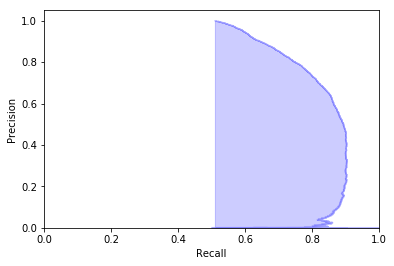

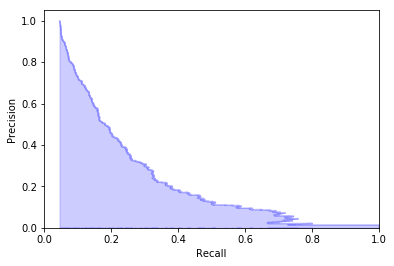

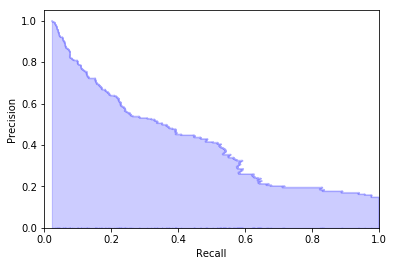

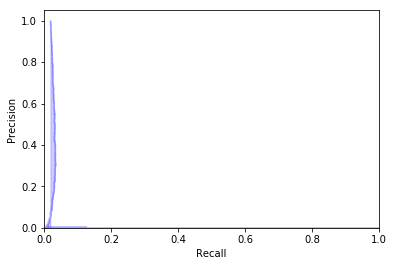

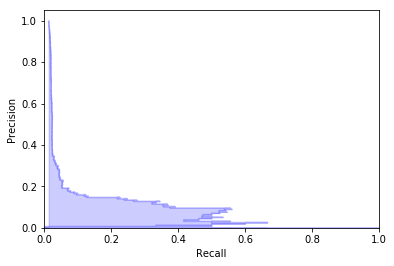

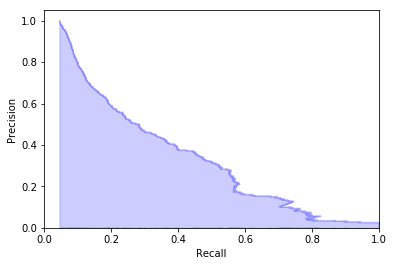

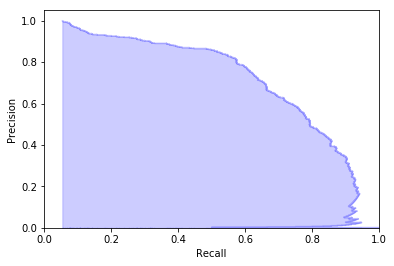

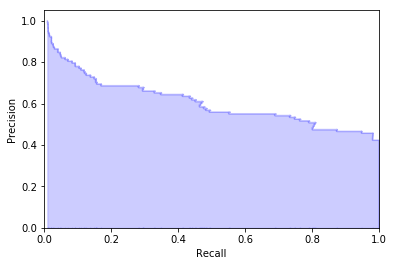

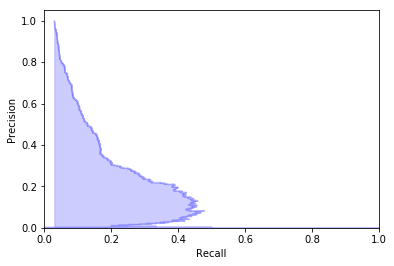

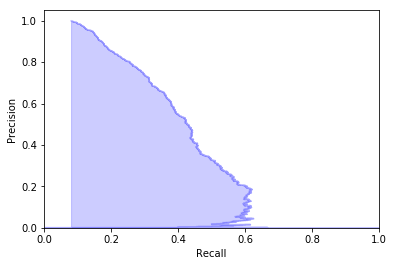

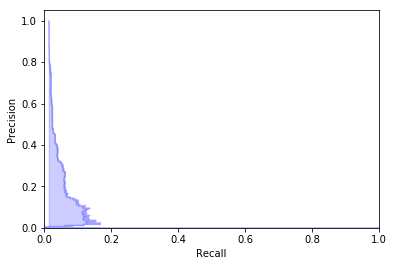

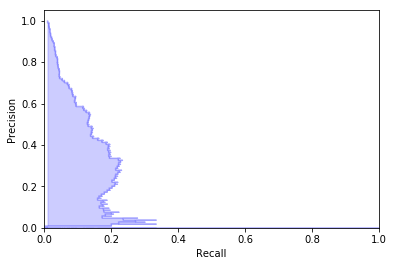

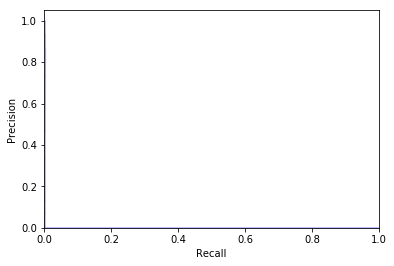

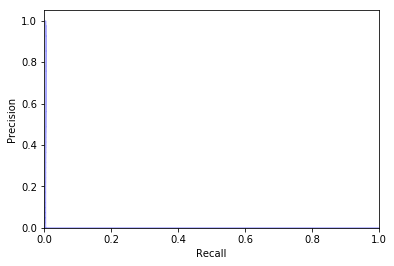

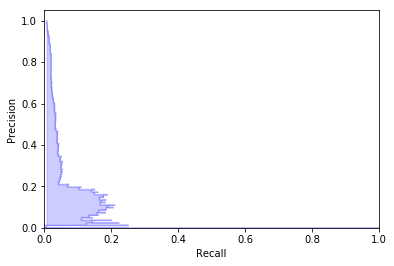

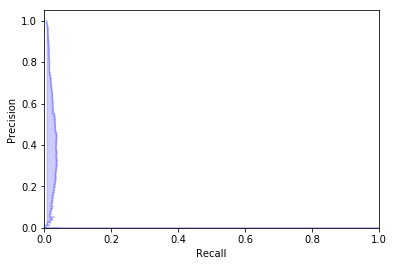

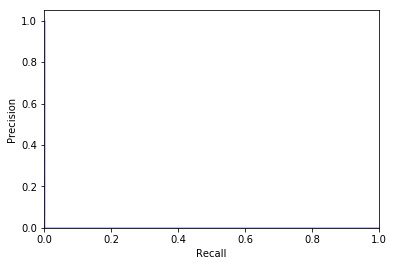

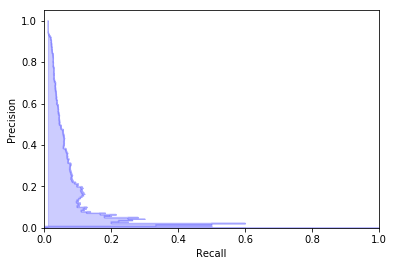

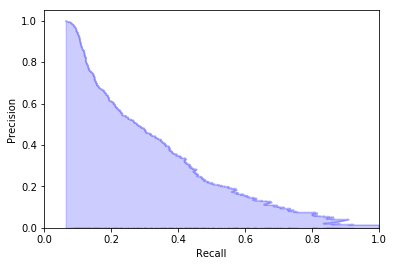

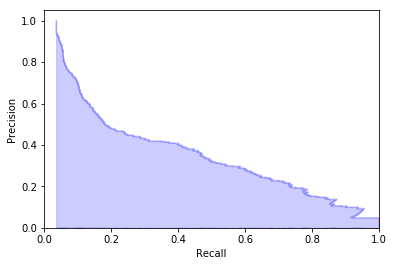

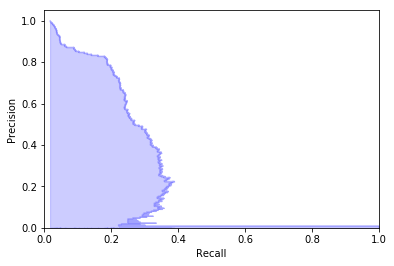

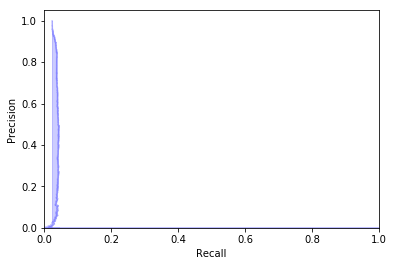

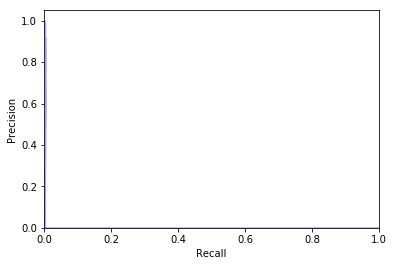

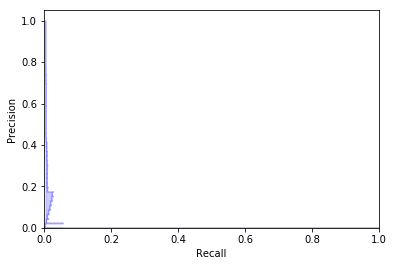

In [25]:
with tf.Session() as sess:

    saver.restore(sess, MODEL_SAVE_PATH)

    test_loss, test_acc, test_precision, test_recall = evaluate(sess, loss, correct_prediction, dataset_init_op,
                                                           feed_dict={head_image_paths_input: test_head_paths,
                                                                      hand_image_paths_input: test_hand_paths,
                                                                      labels: test_labels,
                                                                      is_training: False},
                                                           plot_pr_curve=True)

In [26]:
print('[Test] loss: {} | accuracy: {} | precision: {} | recall: {}'.format(test_loss, test_acc, test_precision, test_recall))

[Test] loss: 0.042062567839715057 | accuracy: 0.571853475266124 | precision: 0.5767912769423797 | recall: 0.571853475266124


In [27]:
# pkl.dump([global_train_acc, global_train_loss, global_train_precision, global_train_recall, global_val_acc, global_val_loss, global_val_precision, global_val_recall], 
#         open('./10-11-original.pkl','wb'))

## Plot train / val metric over epoches

In [32]:
records = {
    'train_acc': global_train_acc, 
    'train_loss': global_train_loss, 
    'train_precision': global_train_precision, 
    'train_recall': global_train_recall, 
    'val_acc': global_val_acc, 
    'val_loss': global_val_loss, 
    'val_precision': global_val_precision,
    'val_recall': global_val_recall,
}

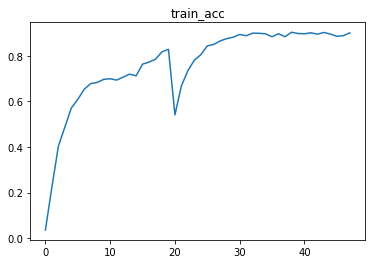

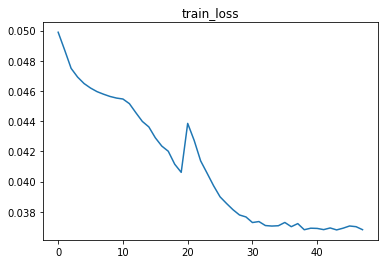

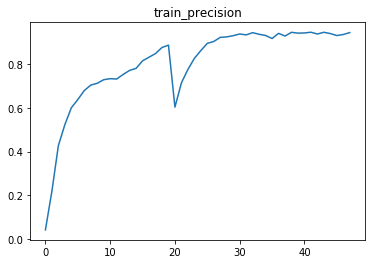

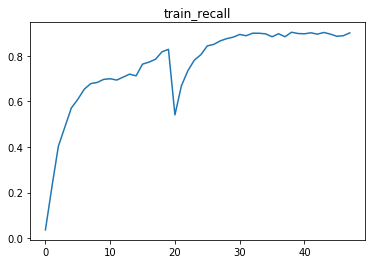

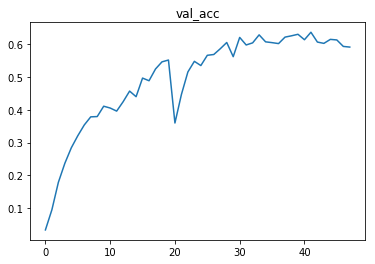

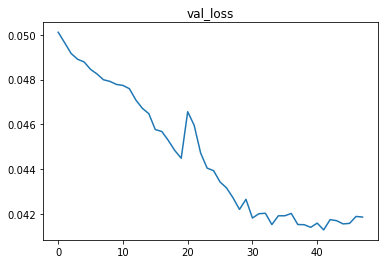

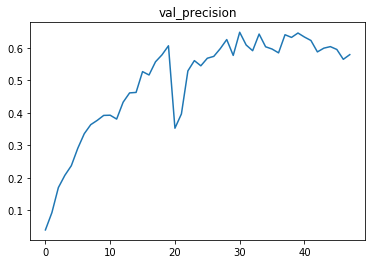

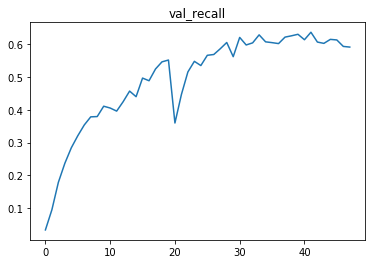

In [34]:
for k in records:
    plt.title(k)
    plt.plot(records[k])
    plt.show()